In [51]:
from datasets import load_dataset
import cv2
import albumentations
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import v2
from tqdm import tqdm

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [53]:
ds = load_dataset("mrm8488/ImageNet1K-val", split="train")

ds

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image', 'label'],
    num_rows: 50000
})

In [54]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=(128, 128), antialias=True),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def transform(examples):
    examples["pixel_values"] = [transforms(image) for image in examples["image"]]
    del examples["image"]
    return examples


ds.set_transform(transform)
train_test = ds.train_test_split(test_size=0.1)

trainloader = torch.utils.data.DataLoader(
    train_test["train"], batch_size=64, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    train_test["train"], batch_size=64, shuffle=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.278791..2.3410368].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.8905451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.9235382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].
Cl

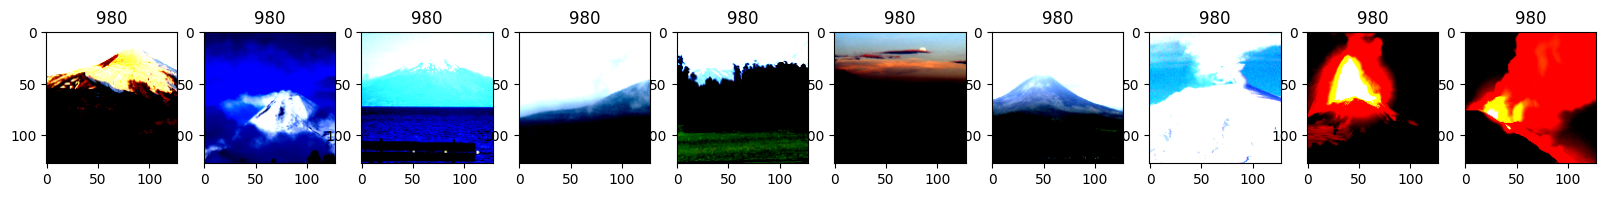

In [55]:
def show_in_row(images, labels):
    n = len(labels)
    plt.figure(figsize=(20, 6))
    for idx, item in enumerate(zip(images, labels)):
        plt.subplot(1, n, idx + 1)
        plt.imshow(item[0].permute(1, 2, 0).numpy())
        plt.title(item[1])
    plt.show()


show_in_row(ds[49000:49010]["pixel_values"], ds[49000:49010]["label"])

In [56]:
class CNN(nn.Module):
    def __init__(self, out_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # 124x124x16
        self.pool = nn.MaxPool2d(2, 2)  # 62x62x16
        self.conv2 = nn.Conv2d(16, 32, 5)  # 58x58x32
        self.fc1 = nn.Linear(26912, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, out_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [57]:
cnn = CNN(1000)
cnn.to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def calc_corrects(model, batch):
    labels, inputs = batch.values()
    labels = labels.to(device)
    inputs = inputs.to(device)
    logits = model(inputs)

    preds = F.softmax(logits, dim=1).argmax(dim=1)
    correct = (preds == labels).sum().item()

    return correct

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        labels, inputs = data.values()
        labels = labels.to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients

        # forward + backward + optimize
        with torch.autocast(device_type=device, dtype=torch.float32):
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print statistics
        running_loss += loss.item()
        running_corrects += calc_corrects(cnn, data)
        if i % 20 == 19:
            print(f"Loss: {running_loss / (i + 1)}")
            print(f"Accuracy: {calc_accuracy(cnn, data)}")

  3%|▎         | 21/704 [00:03<01:38,  6.96it/s]

Loss: 6.850042605400086
Accuracy: 0.0


  6%|▌         | 41/704 [00:05<01:30,  7.35it/s]

Loss: 6.85763828754425
Accuracy: 0.0


  9%|▊         | 61/704 [00:08<01:26,  7.41it/s]

Loss: 6.8560770352681475
Accuracy: 0.0


 12%|█▏        | 81/704 [00:11<01:38,  6.32it/s]

Loss: 6.855226802825928
Accuracy: 0.0


 14%|█▍        | 101/704 [00:14<01:26,  6.97it/s]

Loss: 6.856070680618286
Accuracy: 0.0


 17%|█▋        | 121/704 [00:17<01:20,  7.20it/s]

Loss: 6.854811286926269
Accuracy: 0.015625


 20%|██        | 141/704 [00:20<01:16,  7.33it/s]

Loss: 6.851389629500253
Accuracy: 0.015625


 23%|██▎       | 161/704 [00:22<01:12,  7.50it/s]

Loss: 6.850593599677086
Accuracy: 0.0


 26%|██▌       | 181/704 [00:25<01:09,  7.51it/s]

Loss: 6.850702749358283
Accuracy: 0.0


 29%|██▊       | 201/704 [00:28<01:09,  7.19it/s]

Loss: 6.849531753063202
Accuracy: 0.015625


 31%|███▏      | 221/704 [00:31<01:07,  7.18it/s]

Loss: 6.849625656821511
Accuracy: 0.0


 34%|███▍      | 241/704 [00:34<01:11,  6.45it/s]

Loss: 6.8499840577443445
Accuracy: 0.0


 37%|███▋      | 261/704 [00:36<01:09,  6.37it/s]

Loss: 6.8498426125599785
Accuracy: 0.0


 40%|███▉      | 281/704 [00:39<00:59,  7.16it/s]

Loss: 6.8473352466310775
Accuracy: 0.0


 43%|████▎     | 301/704 [00:42<00:57,  7.02it/s]

Loss: 6.847008345921834
Accuracy: 0.0


 46%|████▌     | 321/704 [00:45<00:55,  6.90it/s]

Loss: 6.846448795497418
Accuracy: 0.0


 48%|████▊     | 341/704 [00:48<00:50,  7.16it/s]

Loss: 6.846996318592745
Accuracy: 0.0


 51%|█████     | 360/704 [00:51<00:45,  7.59it/s]

Loss: 6.847035211986966
Accuracy: 0.0


 54%|█████▍    | 381/704 [00:54<00:46,  7.00it/s]

Loss: 6.846458885544225
Accuracy: 0.0


 57%|█████▋    | 401/704 [00:57<00:42,  7.13it/s]

Loss: 6.845060863494873
Accuracy: 0.015625


 60%|█████▉    | 421/704 [00:59<00:37,  7.53it/s]

Loss: 6.842768898464384
Accuracy: 0.0


 63%|██████▎   | 441/704 [01:02<00:35,  7.33it/s]

Loss: 6.842155982147563
Accuracy: 0.0


 65%|██████▌   | 461/704 [01:05<00:37,  6.49it/s]

Loss: 6.841374075931052
Accuracy: 0.0


 68%|██████▊   | 481/704 [01:08<00:33,  6.63it/s]

Loss: 6.8395041793584825
Accuracy: 0.0


 71%|███████   | 501/704 [01:11<00:30,  6.67it/s]

Loss: 6.838573524475097
Accuracy: 0.0


 74%|███████▍  | 521/704 [01:14<00:25,  7.10it/s]

Loss: 6.8375946695988
Accuracy: 0.0


 77%|███████▋  | 541/704 [01:17<00:23,  7.08it/s]

Loss: 6.837704342382925
Accuracy: 0.0


 80%|███████▉  | 561/704 [01:20<00:20,  7.10it/s]

Loss: 6.835754083735602
Accuracy: 0.0


 83%|████████▎ | 581/704 [01:23<00:16,  7.25it/s]

Loss: 6.834831076654894
Accuracy: 0.0


 85%|████████▌ | 601/704 [01:26<00:14,  7.01it/s]

Loss: 6.833422331015269
Accuracy: 0.0


 88%|████████▊ | 621/704 [01:28<00:11,  7.35it/s]

Loss: 6.833159502090946
Accuracy: 0.015625


 91%|█████████ | 638/704 [01:31<00:09,  6.87it/s]